# Exploratory Models

In [37]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, f1_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline

# color palette 
import matplotlib.colors as cplt
c1 = '#6DB1BF' # cyan
c2 = '#315659' # blue
c3 = '#F98948' # orange
c4 = '#C0DA74' # green
c5 = '#859750' # dark green

data = pd.read_csv('Clean - Modeling.csv',index_col='url')

# Found these two articles to have some errors so I took them out
data = data.drop(index=['http://mashable.com/2014/08/18/ukraine-civilian-convoy-attacked/',
                        'http://mashable.com/2013/12/09/wearably/'])

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39466 entries, http://mashable.com/2013/01/07/amazon-instant-video-browser/ to http://mashable.com/2014/12/27/youtube-channels-2015/
Data columns (total 57 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   n_tokens_title                39466 non-null  float64
 1   n_tokens_content              39466 non-null  float64
 2   n_unique_tokens               39466 non-null  float64
 3   n_non_stop_words              39466 non-null  float64
 4   n_non_stop_unique_tokens      39466 non-null  float64
 5   num_hrefs                     39466 non-null  float64
 6   num_self_hrefs                39466 non-null  float64
 7   num_imgs                      39466 non-null  float64
 8   num_videos                    39466 non-null  float64
 9   average_token_length          39466 non-null  float64
 10  num_keywords                  39466 non-null  float64
 11  self_reference_mi

# K Means Clustering

Start by finding the best amount of clusters for the model

Text(0.5, 0, 'N Clusters')

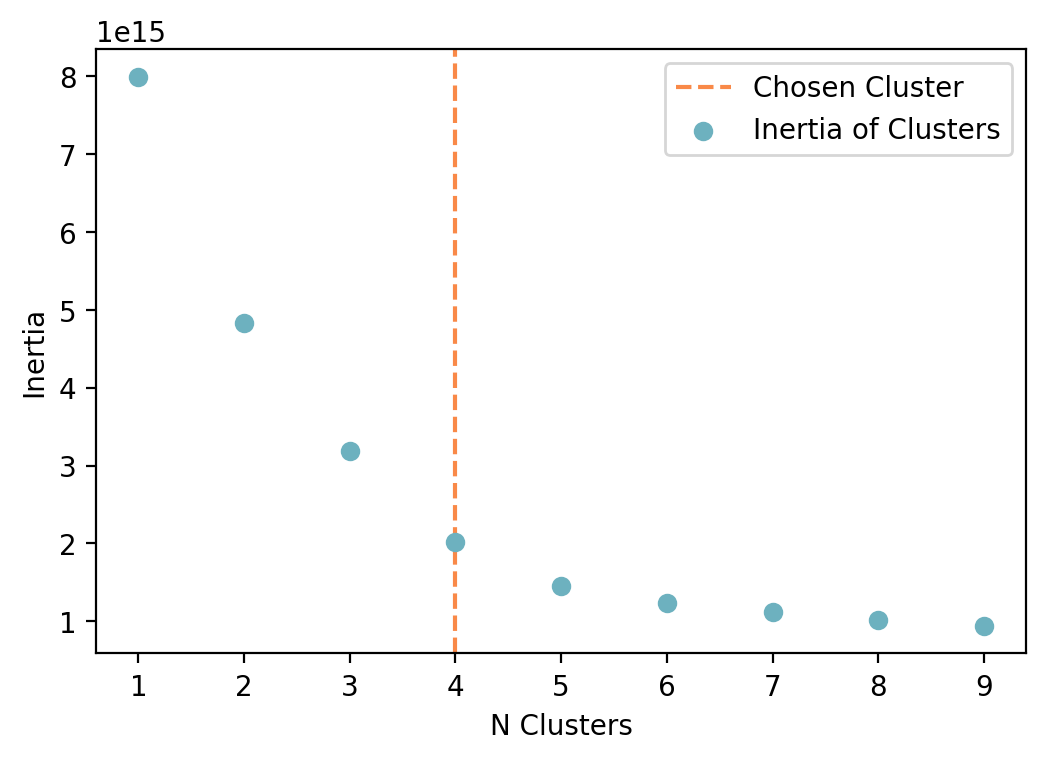

In [38]:
model_data_km = data.copy().drop(columns='shares')

K_range = range(1,10)
inertia = []

for k in K_range:
    scaler = StandardScaler()
    scaler.fit(model_data_km)
    scaler.transform(model_data_km)
    model = KMeans(n_clusters=k)
    model.fit(model_data_km)
    inertia.append(model.inertia_)

plt.figure(figsize=(6,4),dpi=200)
plt.axvline(4,linestyle='--',c=c3,zorder=0,label='Chosen Cluster')
plt.scatter(K_range,inertia,c=c1,zorder=1,label='Inertia of Clusters')
plt.legend()
plt.ylabel('Inertia')
plt.xlabel('N Clusters')

Four looks like a good 'elbow' point, so I'll use four clusters

In [39]:
model_data_km = data.copy().drop(columns='shares')

X_km = model_data_km
k = 4

pipe = Pipeline(steps=[('scaler', StandardScaler()), ('KMean', KMeans(n_clusters=k))])
pipe.fit(X_km)

label=pipe.predict(X_km)

model_data_km['label'] = label+1
model_data_km['shares'] = data['shares']

model_data_km.label.value_counts()

1    15092
3    13071
2    10129
4     1174
Name: label, dtype: int64

After running the model a couple times, the same two articles always got their own cluster. Upon further inspection it seemed that all text related columns had a value of zero despite the fact that the article did indeed have text. Another strange thing was that the values of self_reference_max_shares were less than that of self_reference_min_shares. These must have been errors so they were removed from the dataset

In [46]:
np.seterr(divide='ignore', invalid='ignore')
plt.figure(figsize=(16,60),dpi=300)
plt.subplots_adjust(hspace=0.6,wspace=0.3)

# some labels for the axes
ax_label = ['Amount of Tokens in Title','Amount of Tokens in Content','Rate of Unique Tokens',
            'Rate of Non-stop Words','Rate of Non-stop Unique Tokens','Amount of References',
            'Amount of References to Mashable Articles','Amount of Images','Amount of Videos',
            'Average Token Length','Amount of Keywords','Shares of the Worst Referenced Article',
            'Shares of the Best Referenced Article','Average Sharse of Referenced Articles',
            'Closeness to LDA 0','Closeness to LDA 1','Closeness to LDA 3','Closeness to LDA 4',
            'Subjectivity Level of Content','Polarity Level of Content',
            'Rate of Positive Words in Content','Rate of Negative Words in Content',
            'Rate of Positive Words Among Non-Neutral Tokens','Rate of Hegative Words Among Non-Neutral Tokens',
            'Average Polarity of Positive Words','Minimum Polarity of Positive Words',            
            'Maximum Polarity of Positive Words','Average Polarity of Negative Words',
            'Minimum Polarity of Negative Words','Maximum Polarity of Negative Words',
            'Title Subjectivity Level','Title Polarity Level','Absolute Subjectivity Level',
            'Absolute Polarity Level','Min Shares of the Worst Keyword','Avg Shares of the Worst Keyword',
            'Max Shares of the Worst Keyword','Min Shares of the Median Keyword',
            'Avg Shares of the Median Keyword','Max Shares of the Medain Keyword',
            'Min Shares of the Best Keyword','Avg Shares of the Best Keyword','Max Shares of the Best Keyword']

cmap = cplt.ListedColormap([c3,c1,c2,c4])

for n,col_name in enumerate(model_data_km.select_dtypes('number').columns[:44],start=1):
    range_lim = None
    five_std_lim = model_data_km[col_name].mean() + 3*model_data_km[col_name].std()
    if model_data_km[col_name].max() > five_std_lim:
        range_lim=(model_data_km[col_name].min(),np.percentile(model_data_km[col_name],90))
    
    plt.subplot(15,3,n)
    sns.histplot(data=model_data_km,
                 x=col_name,hue="label",
                 palette=cmap,
                 bins=10,
                 element='step',
                 legend=False,
                 fill=False,
                 binrange=range_lim)
    plt.title(col_name)
    plt.xlabel(ax_label[n-1])
    
plt.legend(('Cluster 4', 'Cluster 3', 'Cluster 2','Cluster 1'),ncol=4, bbox_to_anchor=(1.2,23.8));

Text(0.5, 0, 'cluster')

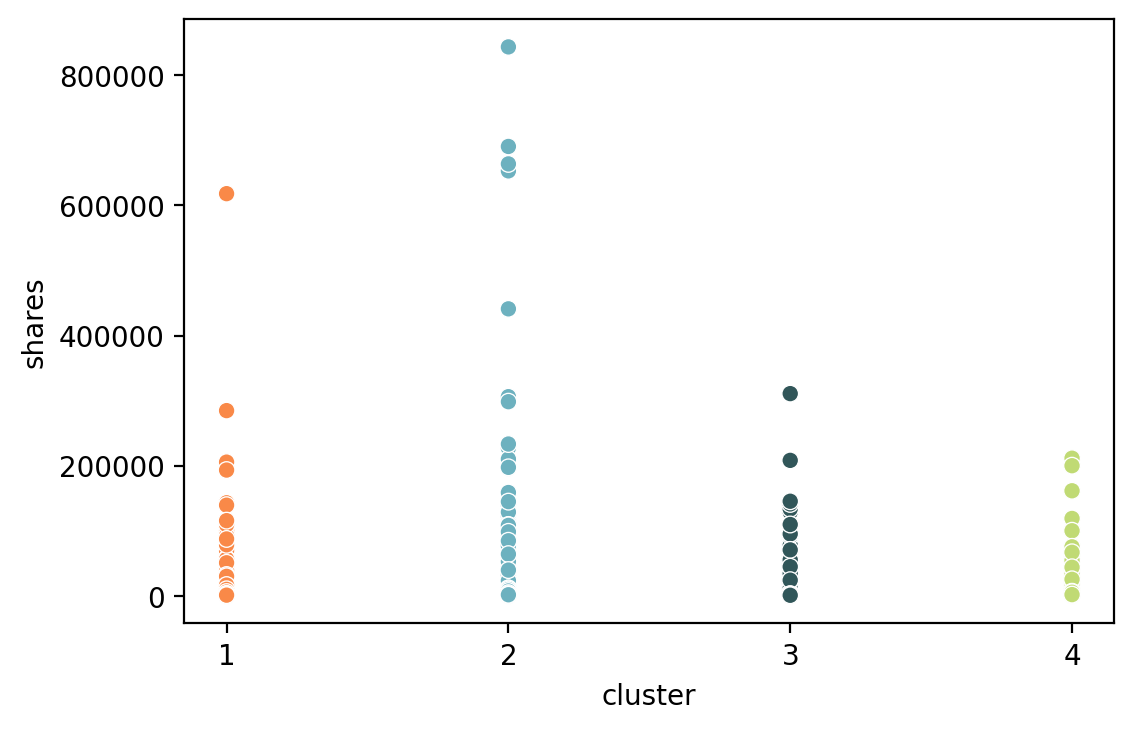

In [47]:
import matplotlib.ticker as ticker
plt.figure(figsize=(6,4),dpi=200)
ax=plt.subplot()
sns.scatterplot(data=model_data_km,x='label',y='shares',hue='label',palette=cmap,legend=False)
ax.xaxis.set_major_locator(ticker.FixedLocator([1,2,3,4]))
plt.xlabel('cluster')

From what i can gather from these histograms...
 - Cluster 1 (orange): less words and positive
 - Cluster 3 (dark blue): less words and negative
 - Cluster 2 (cyan): Wordy, with more refrences, slighly more subjective and positive 
 - Cluster 4 (green): no text

In [48]:
pop_label = pd.DataFrame(model_data_km[model_data_km.shares>6200].label.value_counts())
pop_label.reset_index().rename(columns={'index':'label','label':'Popular Entries'}).set_index('label')

,Popular Entries
label,
2,1510
1,1248
3,974
4,192


Cluster 2 has the most popular articles followed by Cluster 1, this might suggest that positivity makes an article more likely to be popular. 

# PCA

To better visualize these clusters, let's see what they look like after PCA

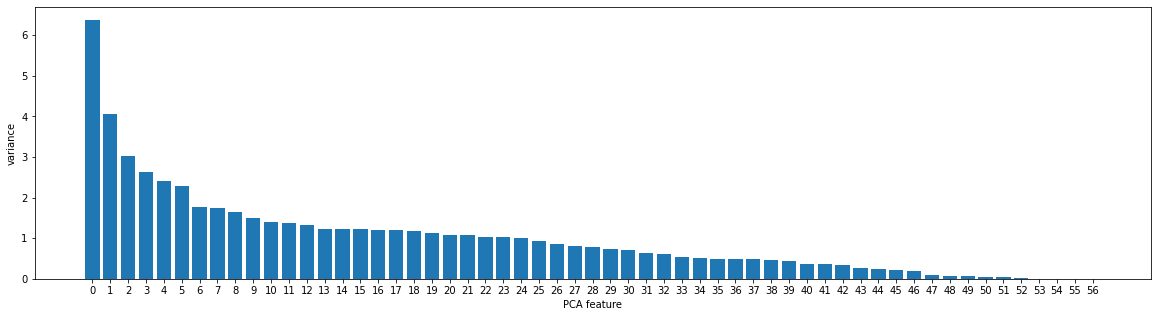

In [49]:
data_pca = model_data_km.copy()

X_pca = data_pca.drop(columns=['shares'])

# Create PCA instance: model
X_pca = StandardScaler().fit_transform(X_pca)
model = PCA().fit(X_pca)

# Apply the fit_transform method of model to grains: pca_features
pca_features = model.transform(X_pca)
features = pd.DataFrame({'features':range(0,model.n_components_),'varience':model.explained_variance_}).set_index('features')
pca_features = pd.DataFrame(pca_features)

# Plot the explained variances
plt.figure(figsize=(20,5))
plt.bar(features.index,features.varience )
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features.index)
plt.show()

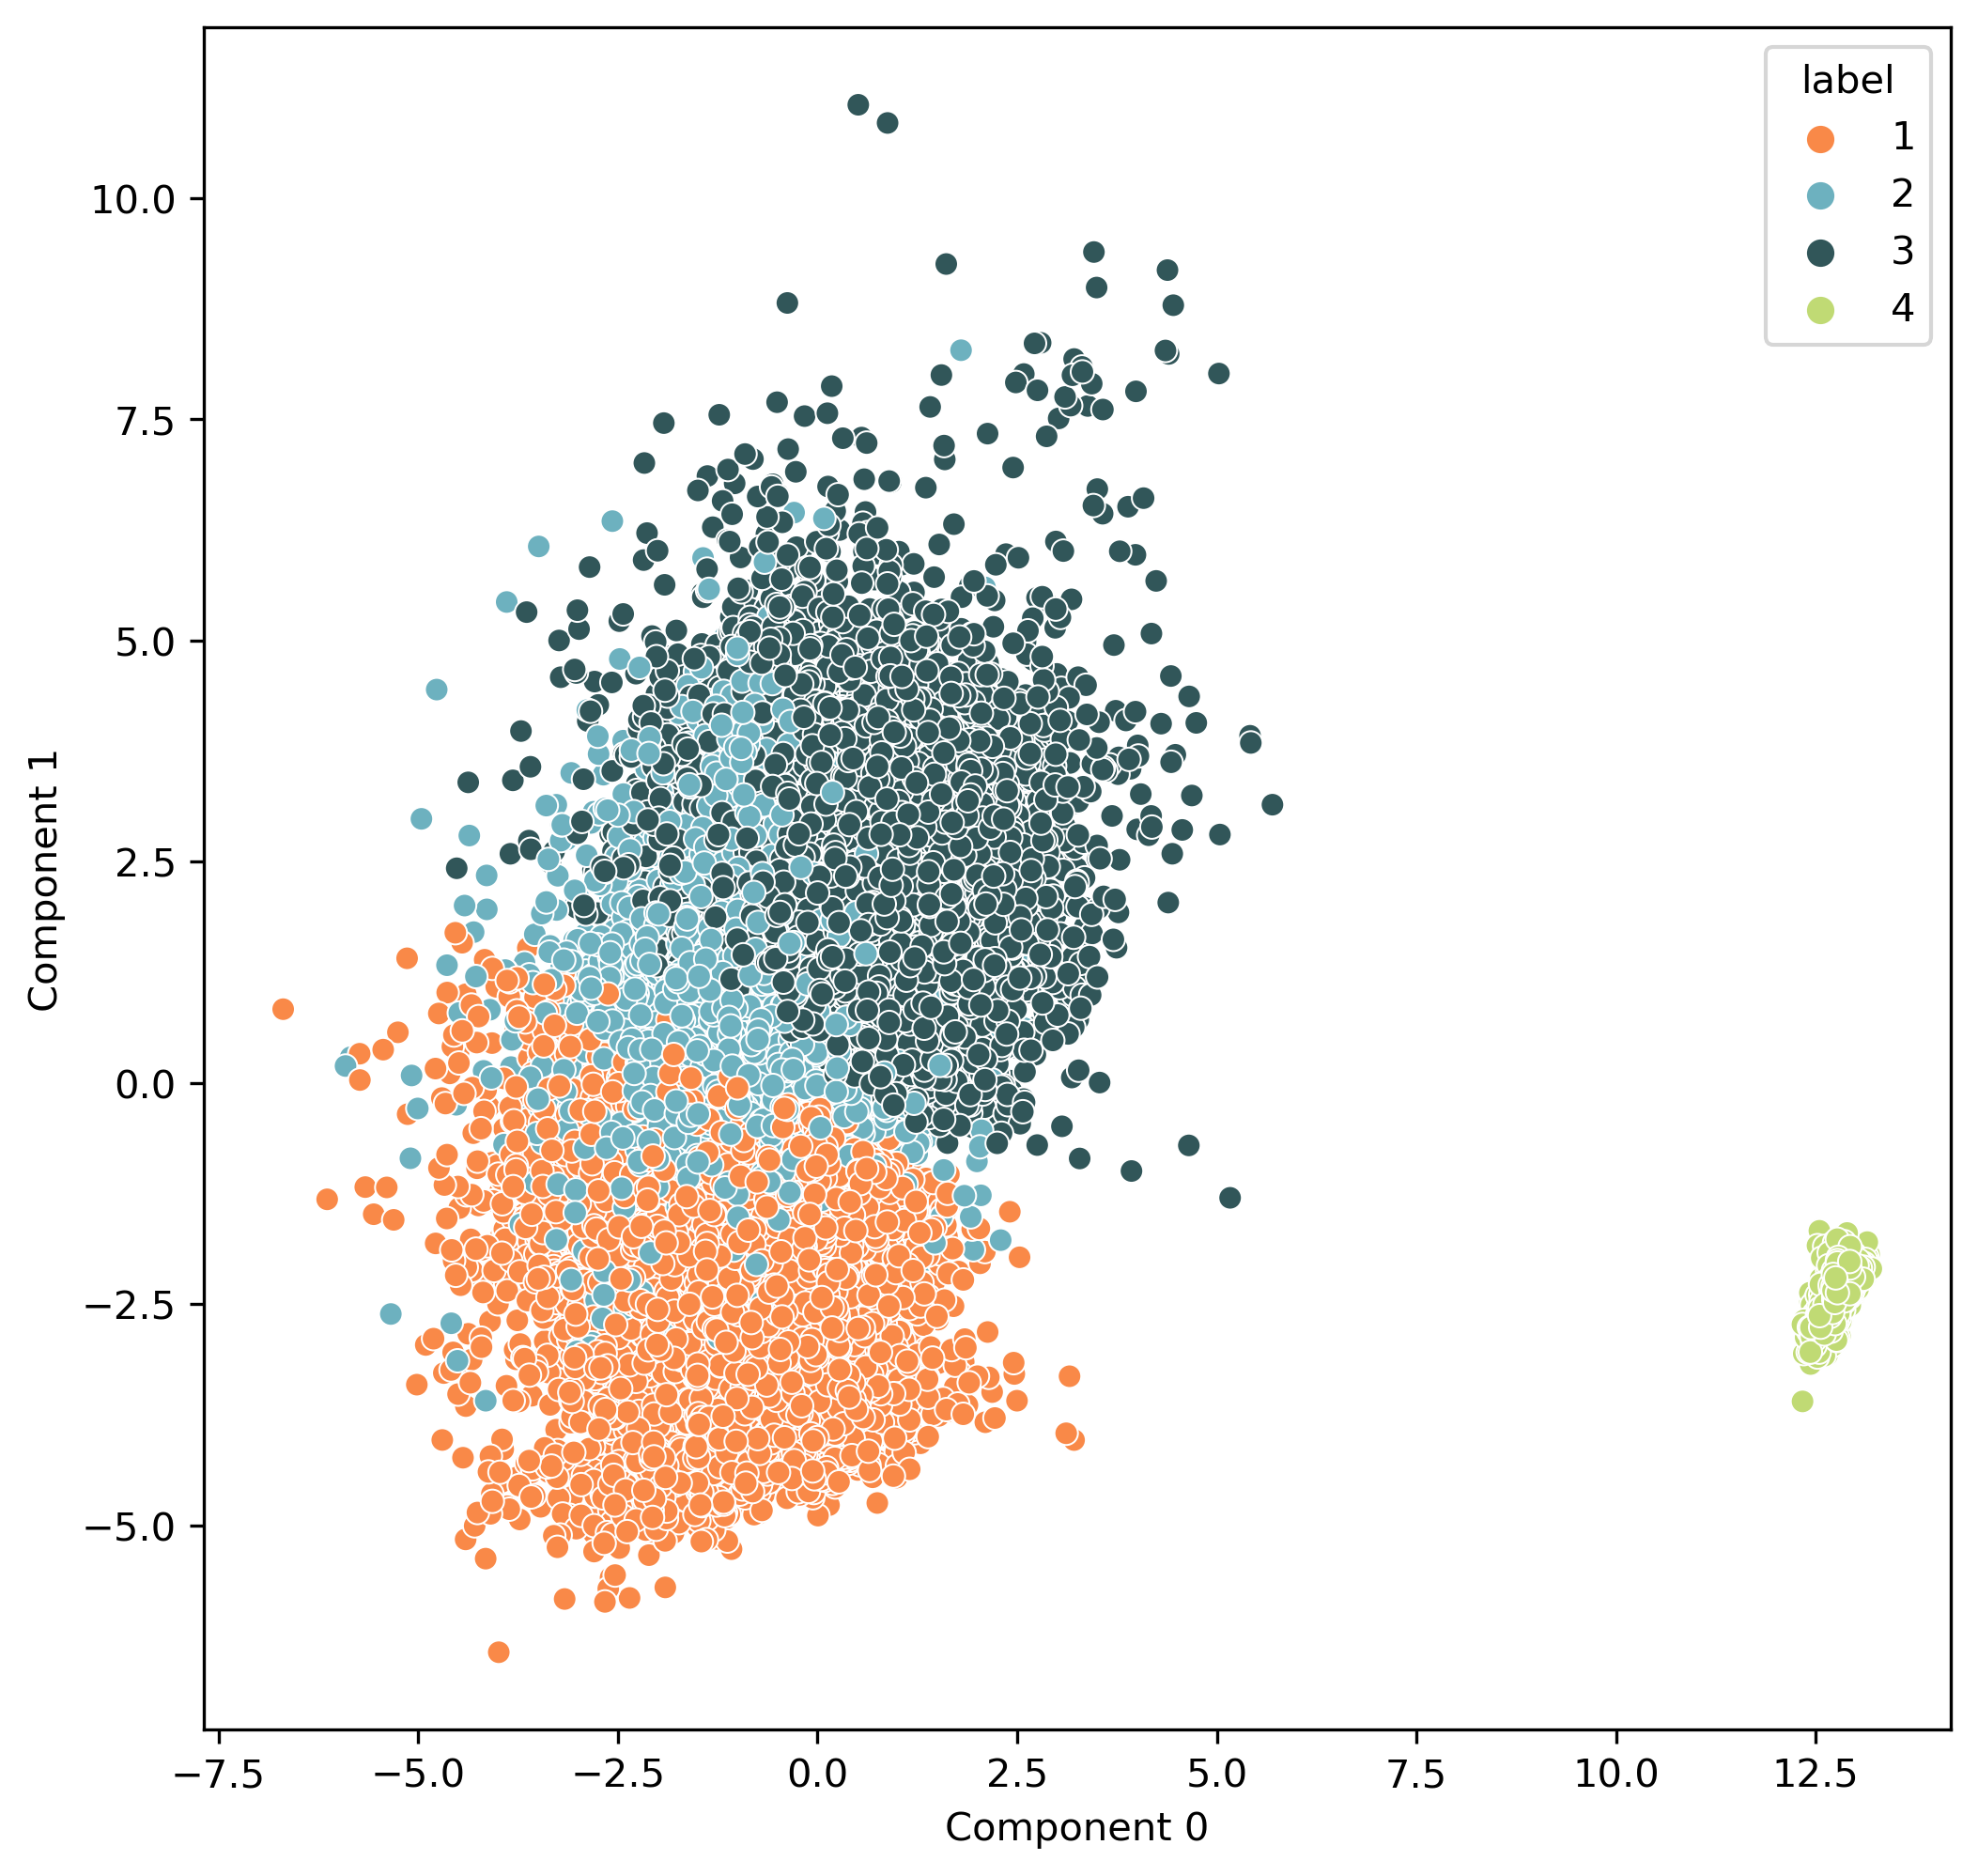

In [61]:
# attach labels to pca components
pca_features['label'] = data_pca.label.values
features_01 = pca_features[[0,1,'label']].rename(columns={0:'0',1:'1'})

cmap = cplt.ListedColormap([c3,c1,c2,c4])


# Plot
plt.figure(figsize=(8,8),dpi=300)
sns.scatterplot(data=features_01,x='0',y='1',hue='label',palette=cmap,legend=True)
plt.xlabel('Component 0')
plt.ylabel('Component 1');

Cluster 4 is understandably quite different from the rest. It appears cluster 1 and cluster 3 seem to be part of the same blob, but have a rather definitive line between them. Both of these seem to overlap with cluster 2.

# Random Forest Models

In [8]:
def best_depth(X,y,k,score):
    """
    Finds best depth of the model based off of the 
    """ 
    pipe = Pipeline(steps=[('scaler', StandardScaler()), ('random_forest', RandomForestClassifier())])
    grid = GridSearchCV(pipe,param_grid={'random_forest__max_depth':k},scoring=score)
    grid.fit(X,y)
    print(grid.best_params_)
    return grid

def make_model(X,y,depth_range=range(5,15),score='recall'):
    """
    Makes a random forest model based off the best K.
    """
    grid = best_depth(X.copy(),y.copy(),depth_range,score)

    depth = grid.best_params_['random_forest__max_depth']
    
    pipe = Pipeline(steps=[('scaler', StandardScaler()), ('random_forest', RandomForestClassifier(max_depth=depth))])
    pipe.fit(X,y)
    return pipe
        
def plot_confusion_matrix(cm,classes,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    Prints and plots a confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Rounding

Quickly see if a simple model can predict an articles share based on the features

### Random Forest

Text(0.5, 1.0, 'Test Accuracy')

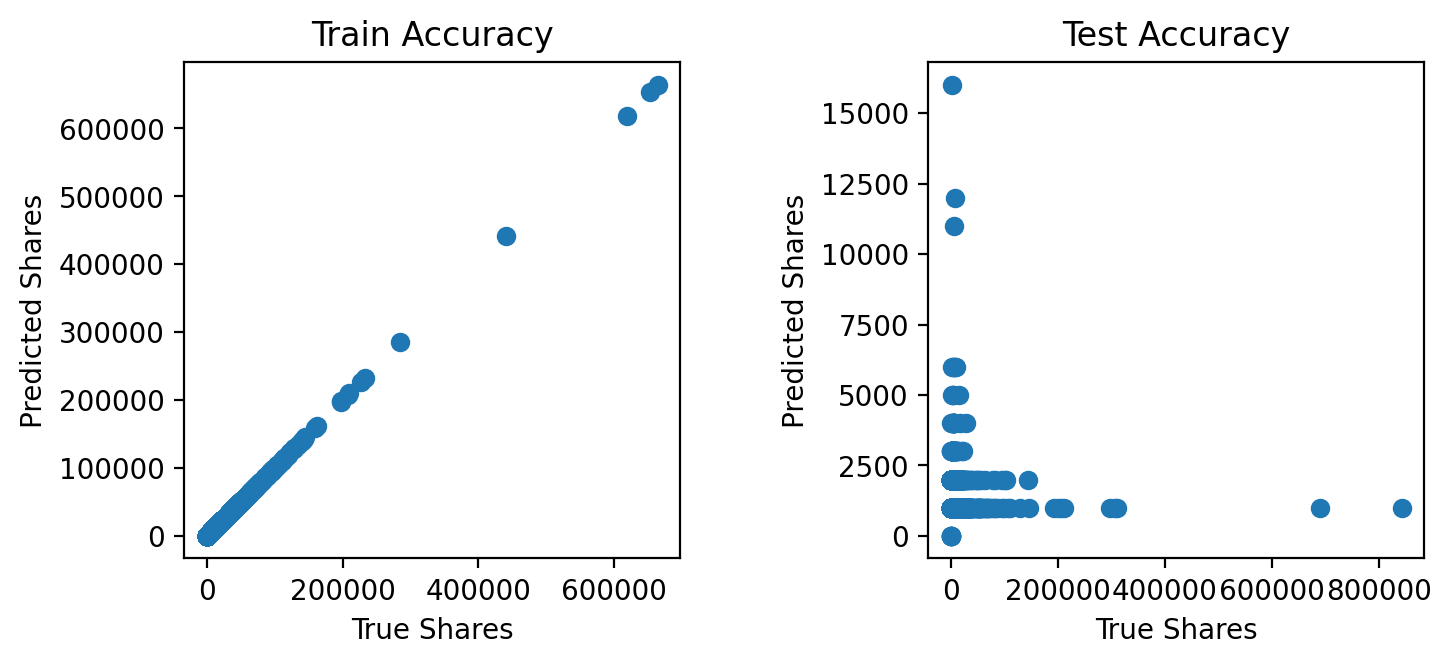

In [9]:
model_data_1 = data.copy()

# round shares to the closest thousand
model_data_1['rounded'] = model_data_1.shares.round(-3)
model_data_1 = model_data_1.drop(columns='shares')

y_var = 'rounded'

X = model_data_1.drop(columns=y_var)
y = model_data_1[y_var]

# split data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20)

# make model
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('RForest', RandomForestClassifier())])

# fit model and predict
pipe.fit(X_train,y_train)
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

# plot accuracy
plt.figure(figsize=(8,4),dpi=200)
plt.subplots_adjust(hspace=0.5,wspace=0.5)

ax1 = plt.subplot(121)
ax1.set_box_aspect(1)
plt.scatter(y_train,y_pred_train)
plt.xlabel('True Shares')
plt.ylabel('Predicted Shares')
plt.title('Train Accuracy')

ax2 = plt.subplot(122)
ax2.set_box_aspect(1)
plt.scatter(y_test,y_pred_test)
plt.xlabel('True Shares')
plt.ylabel('Predicted Shares')
plt.title('Test Accuracy')

### Linear Regression

Text(0.5, 1.0, 'Test Accuracy')

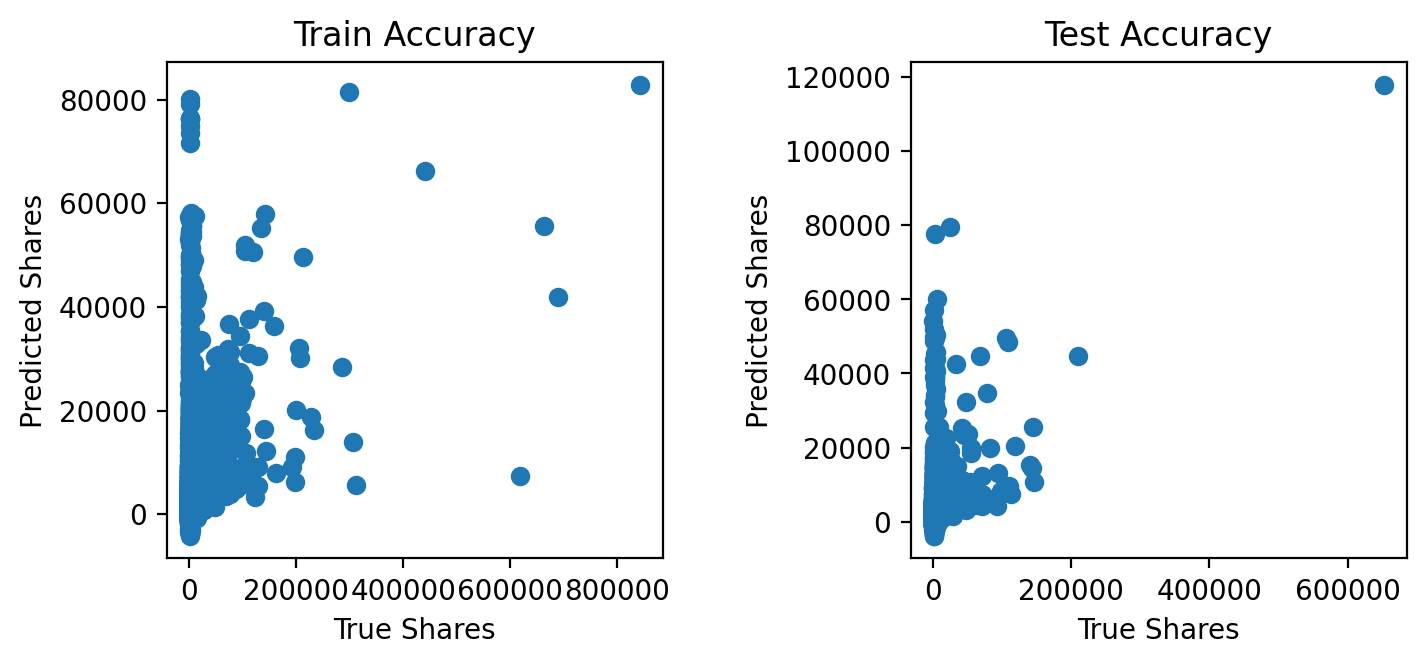

In [10]:
model_data_1 = data.copy()

# round shares to the closest thousand
model_data_1['rounded'] = model_data_1.shares.round(-3)
model_data_1 = model_data_1.drop(columns='shares')

y_var = 'rounded'

X = model_data_1.drop(columns=y_var)
y = model_data_1[y_var]

# split data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20)

# make model
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('LinReg', LinearRegression())])

# fit model and predict
pipe.fit(X_train,y_train)
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

# plot accuracy
plt.figure(figsize=(8,4),dpi=200)
plt.subplots_adjust(hspace=0.5,wspace=0.5)

ax1 = plt.subplot(121)
ax1.set_box_aspect(1)
plt.scatter(y_train,y_pred_train)
plt.xlabel('True Shares')
plt.ylabel('Predicted Shares')
plt.title('Train Accuracy')

ax2 = plt.subplot(122)
ax2.set_box_aspect(1)
plt.scatter(y_test,y_pred_test)
plt.xlabel('True Shares')
plt.ylabel('Predicted Shares')
plt.title('Test Accuracy')

Can't really predict shares with any accuracy. Lets try simplifying the criteria with a multi classification set-up instead.

# Three Brackets
Seperating the entries into three seperate brackets based on percentiles

In [11]:
model_data_2 = data.copy()

def popularity_3(data,col_name):
    """
    Labels data as 'popular','average' or 'unpopular' based on the 30th and 95th percentile
    """
    avg = int(np.percentile(data['shares'],[0,30])[1])
    high = int(np.percentile(data['shares'],[0,90])[1])
    
    data.loc[data[(data['shares'] > high)].index,col_name] = 'popular'
    data.loc[data[(data['shares'] >= avg) & (data['shares'] <= high)].index,col_name] = 'average'
    data.loc[data[data['shares'] < avg].index,col_name] = 'unpopular'
    return data.drop(columns='shares')
    
    return data

y_var = 'popularity'

model_data_2 = popularity_3(model_data_2,y_var)

y_var_values = model_data_2[y_var].unique()
X = model_data_2.drop(columns=y_var)
y = model_data_2[y_var].replace(y_var_values,range(len(y_var_values)))
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20,stratify=y)

# Print Distribution

def print_values(y_train,y_test):
    train = y_train.value_counts()
    train = train.append(pd.Series({'total':train.sum()}))
    train = pd.DataFrame(train,columns=['train'])

    test = y_test.value_counts()
    test = test.append(pd.Series({'total':test.sum()}))
    test = pd.DataFrame(test,columns=['test'])

    entries = train.join(test).T

    entries = entries.append(entries.sum().rename('total'))
    
    return(entries)
    
print_values(y_train,y_test)

,1,0,2,total
train,19476,8957,3139,31572
test,4870,2239,785,7894
total,24346,11196,3924,39466


{'random_forest__max_depth': 14}
0.7872165209679463 0.6478337978211299


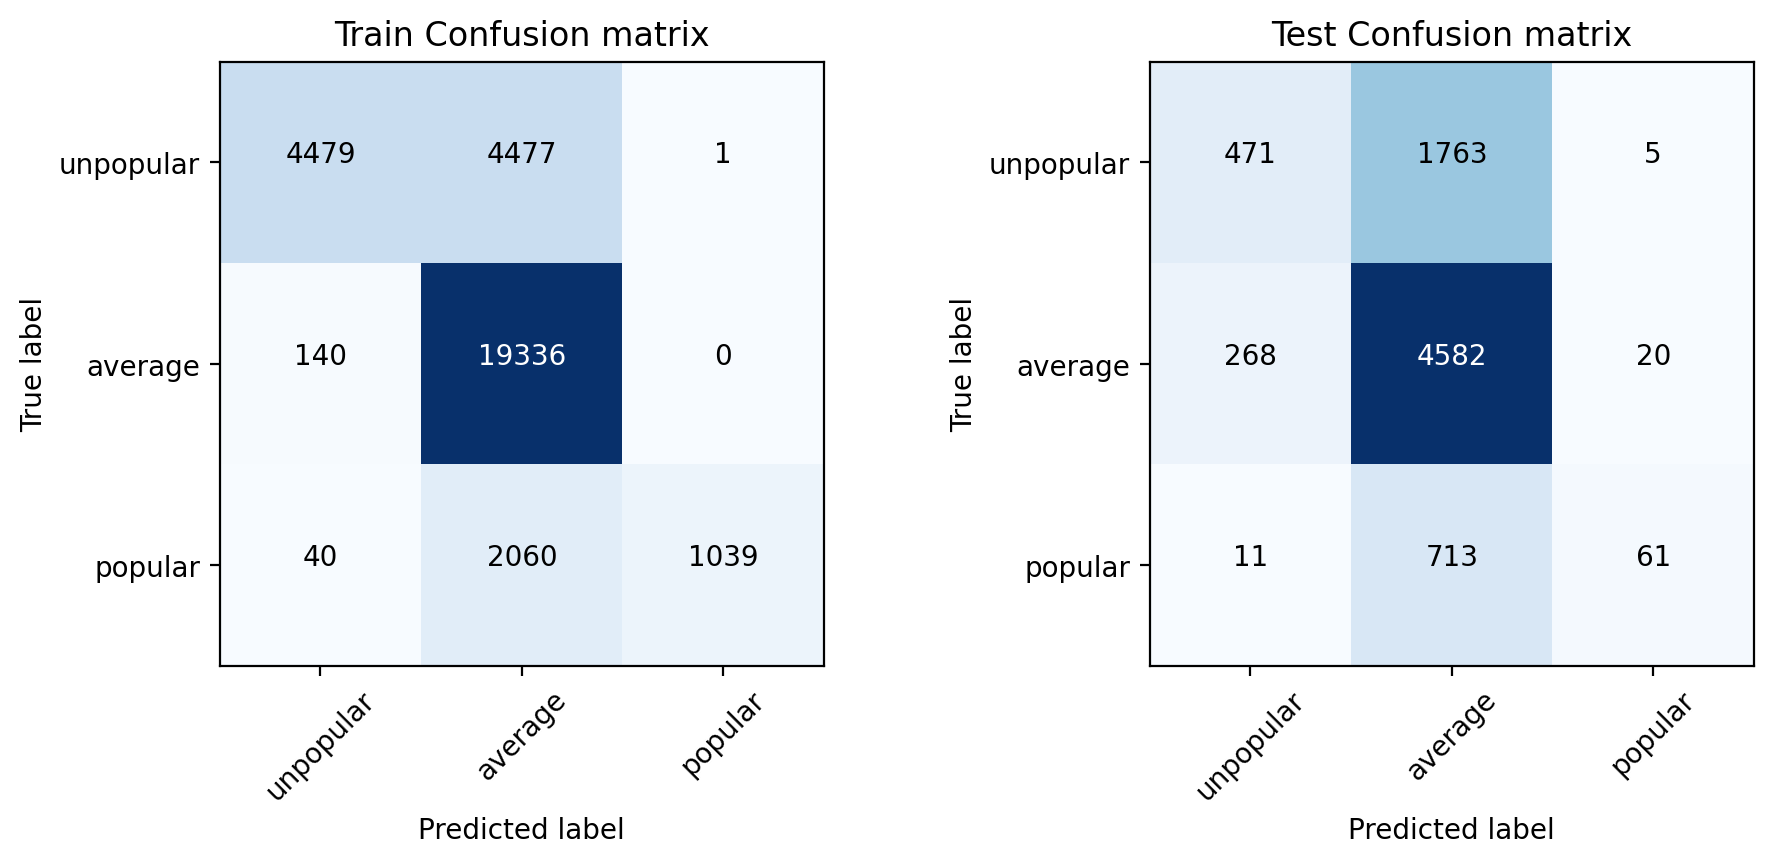

In [12]:
# Make model
model = make_model(X_train, y_train,depth_range=range(10,15),score='accuracy')

# Test model
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

training_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(training_accuracy,test_accuracy)

cnf_matrix_test = confusion_matrix(y_test, y_pred_test)
cnf_matrix_train = confusion_matrix(y_train, y_pred_train)

# Plot Confusion Matrix
plt.figure(figsize=(10,10),dpi=200)
plt.subplots_adjust(hspace=0.5,wspace=0.5)

plt.subplot(221)
plot_confusion_matrix(cnf_matrix_train,classes=y_var_values, title='Train Confusion matrix')

plt.subplot(222)
plot_confusion_matrix(cnf_matrix_test,classes=y_var_values, title='Test Confusion matrix')

Seems it misclassifing alot of entries as `average`, probably since there are so many entries in that catergory. I'll try limiting the amount of entries so that there is an equal amount of all of them.

In [13]:
def lim_entries(X_train, X_test, y_train, y_test):
    '''
    Limits the points in the training set such that all all labels are equal.
    Adds cut points to the testing set. 
    '''
    y_var = y_train.name
    data = X_train.join(y_train)
    entries = list(data[y_var].value_counts().index[:-1])
    n = list(data[y_var].value_counts())[-1]
    new = data.loc[data[y_var] == data[y_var].value_counts().index[-1]]
    
    for entry in entries:
        selected = data[data[y_var] == entry].reset_index()
        selected_col = selected.columns
        index = selected_col[0]
        selected = pd.DataFrame(np.random.permutation(selected)[:n],columns=selected_col).set_index(index)
        new = new.append(selected) 
        
    cut = data.drop(index=list(new.index))
    
    X_train = new.drop(columns=y_var)
    y_train = new[y_var]
    X_test = X_test.append(cut.drop(columns=y_var))
    y_test = y_test.append(cut[y_var])

    return X_train.astype('float'), X_test.astype('float'), y_train.astype('float'), y_test.astype('float')

# Split data
X_train_lim, X_test_lim, y_train_lim, y_test_lim = lim_entries(X_train, X_test, y_train, y_test)
print_values(y_train_lim,y_test_lim)

,0.0,1.0,2.0,total
train,3139,3139,3139,9417
test,8057,21207,785,30049
total,11196,24346,3924,39466


{'random_forest__max_depth': 10}
0.7990867579908676 0.43858364671037303


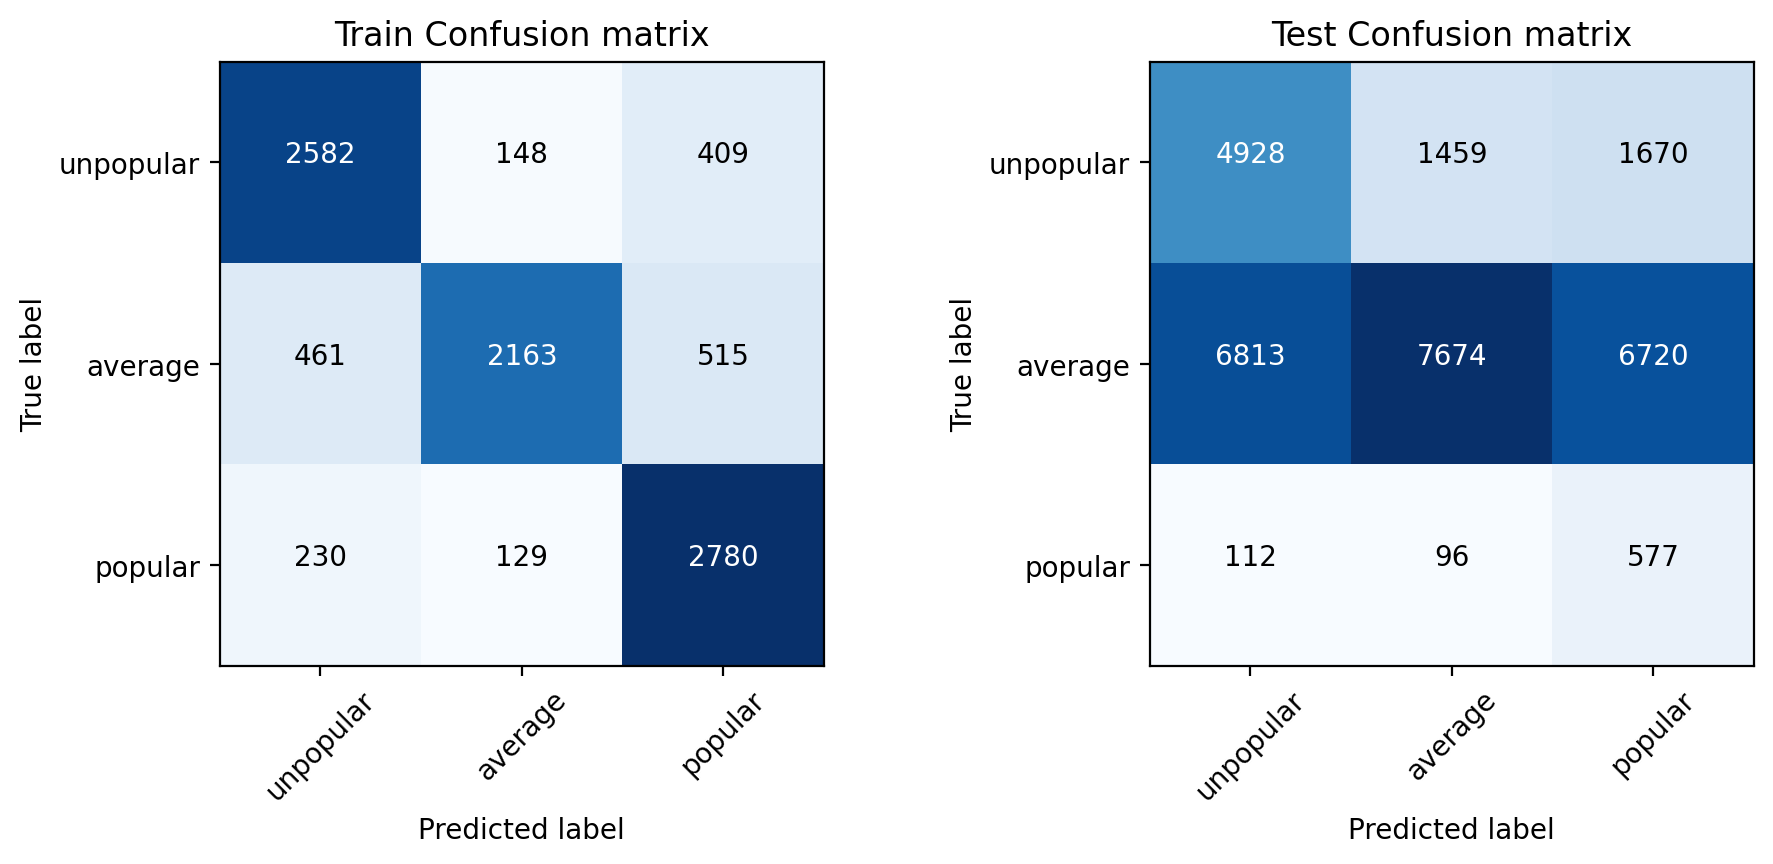

In [14]:
# Make model
model = make_model(X_train_lim, y_train_lim,depth_range=range(10,15),score='accuracy')

# Test model
y_pred_train = model.predict(X_train_lim)
y_pred_test = model.predict(X_test_lim)

training_accuracy = accuracy_score(y_train_lim, y_pred_train)
test_accuracy = accuracy_score(y_test_lim, y_pred_test)
print(training_accuracy,test_accuracy)

cnf_matrix_test = confusion_matrix(y_test_lim, y_pred_test)
cnf_matrix_train = confusion_matrix(y_train_lim, y_pred_train)

# Plot Confusion Matrix
plt.figure(figsize=(10,10),dpi=200)
plt.subplots_adjust(hspace=0.5,wspace=0.5)

plt.subplot(221)
plot_confusion_matrix(cnf_matrix_train,classes=y_var_values, title='Train Confusion matrix')

plt.subplot(222)
plot_confusion_matrix(cnf_matrix_test,classes=y_var_values, title='Test Confusion matrix')

Confusion matrix looks better but the true positives went down by alot. Since ultimatley we want to identify popular articles, Ill try binary classification with the same popular threshold.

# Binary Classification
Split entries into popular and unpopular

In [15]:
model_data_3 = data.copy()
pop = np.percentile(model_data_3.shares,[0,90])[1]

def popularity_2(data,thresh,col_name):
    """
    Labels data as 'popular' or 'unpopular' based on a given threshold.
    """
    data.loc[data[(data['shares'] > thresh)].index,col_name] = 'popular'
    data.loc[data[data['shares'] <= thresh].index,col_name] = 'unpopular'
    return data.drop(columns='shares')

# Split data
y_var = 'popularity'

model_data_3 = popularity_2(model_data_3,pop,y_var)

y_var_values = model_data_3[y_var].unique()
X = model_data_3.drop(columns=y_var)
y = model_data_3[y_var].replace(y_var_values,range(len(y_var_values)))
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20,stratify=y)

print_values(y_train,y_test)

,0,1,total
train,28433,3139,31572
test,7109,785,7894
total,35542,3924,39466


{'random_forest__max_depth': 14}
Accuracy: 0.9415304700367414 0.9068913098555865
F1 score: 0.5834837545126353 0.15420023014959724


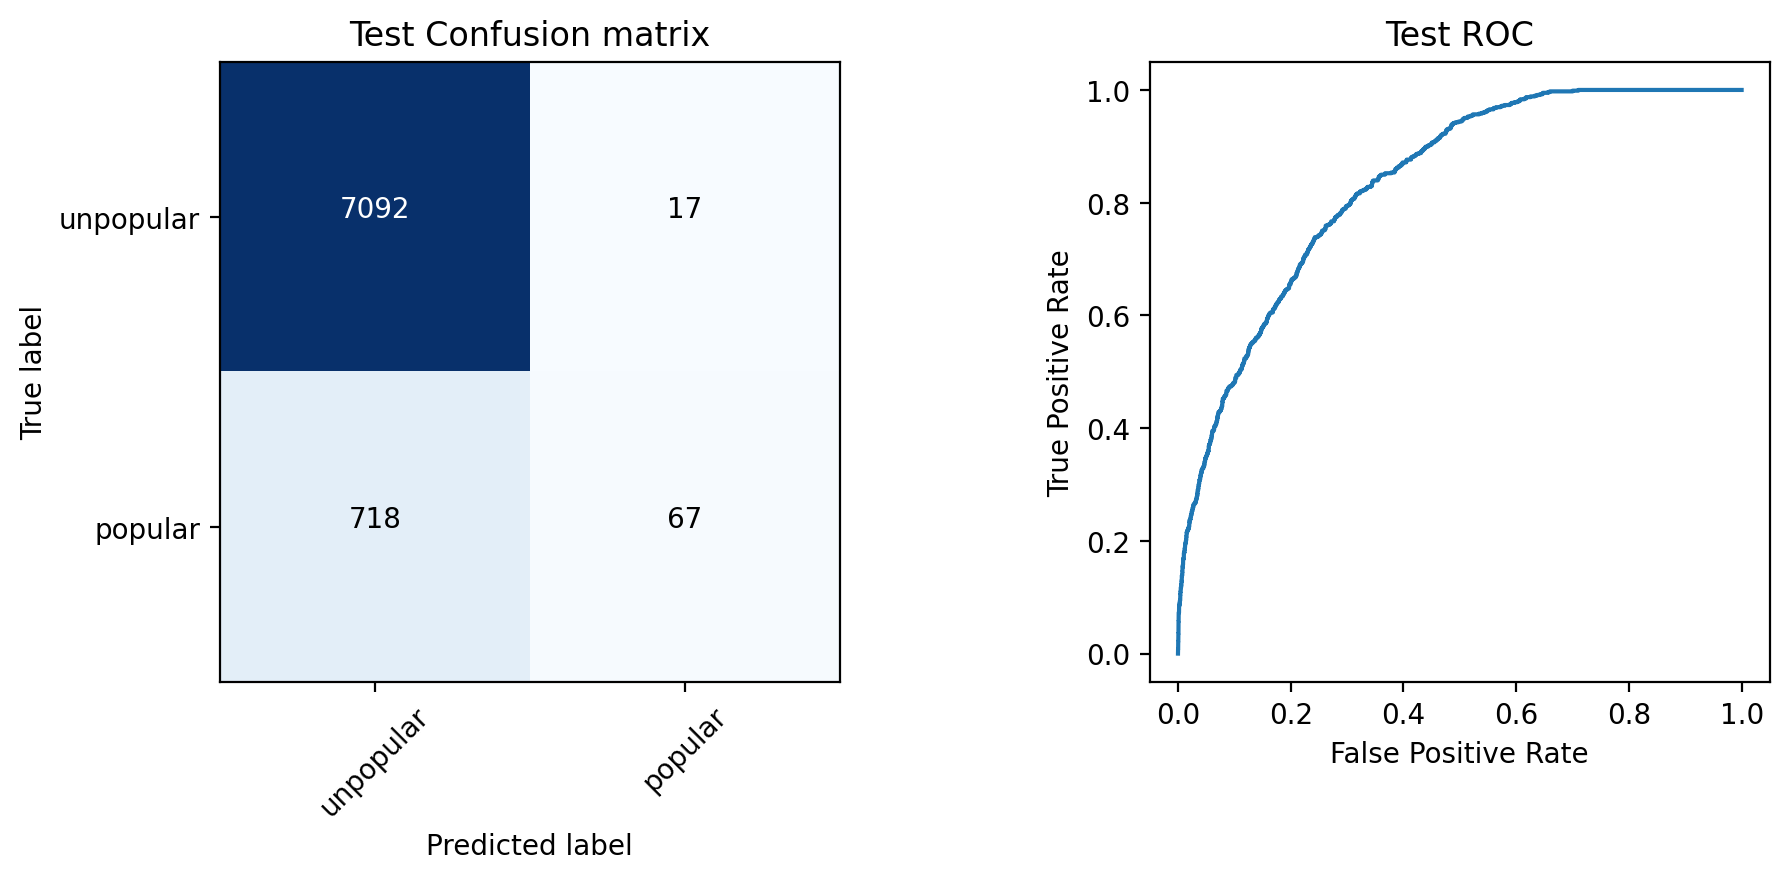

In [16]:
# Make model
model = make_model(X_train, y_train,depth_range=range(10,15),score='f1')

# Test model
def test_model(model,X_train, X_test, y_train, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    y_pred_train_proba = model.predict_proba(X_train)[:, 1]
    y_pred_test_proba = model.predict_proba(X_test)[:, 1]

    # accuracy
    training_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    print('Accuracy:',training_accuracy,test_accuracy)
    
    # f1 score
    training_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test)
    print('F1 score:',training_f1,test_f1)

    # confusion matrix
    cnf_matrix_test = confusion_matrix(y_test, y_pred_test)
    cnf_matrix_train = confusion_matrix(y_train, y_pred_train)

    # roc curve
    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test_proba)

    
    # Set up figures
    plt.figure(figsize=(10,10),dpi=200)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    
    # Plot Confusion Matrix
    ax1=plt.subplot(121)
    plot_confusion_matrix(cnf_matrix_test,classes=y_var_values, title='Test Confusion matrix')

    # Plot ROC Curve
    ax2=plt.subplot(122)
    ax2.set_box_aspect(1)
    plt.title('Test ROC')
    plt.plot(fpr_test, tpr_test)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate');
    
test_model(model,X_train, X_test, y_train, y_test)

# Binary Classificaiton - Limited

In [18]:
# limit points
X_train_lim, X_test_lim, y_train_lim, y_test_lim = lim_entries(X_train, X_test, y_train, y_test)
print_values(y_train_lim,y_test_lim)

,0.0,1.0,total
train,3139,3139,6278
test,32403,785,33188
total,35542,3924,39466


{'random_forest__max_depth': 10}
Accuracy: 0.8918445364765849 0.6899783054115946
F1 score: 0.8948428062567756 0.11002508433526512


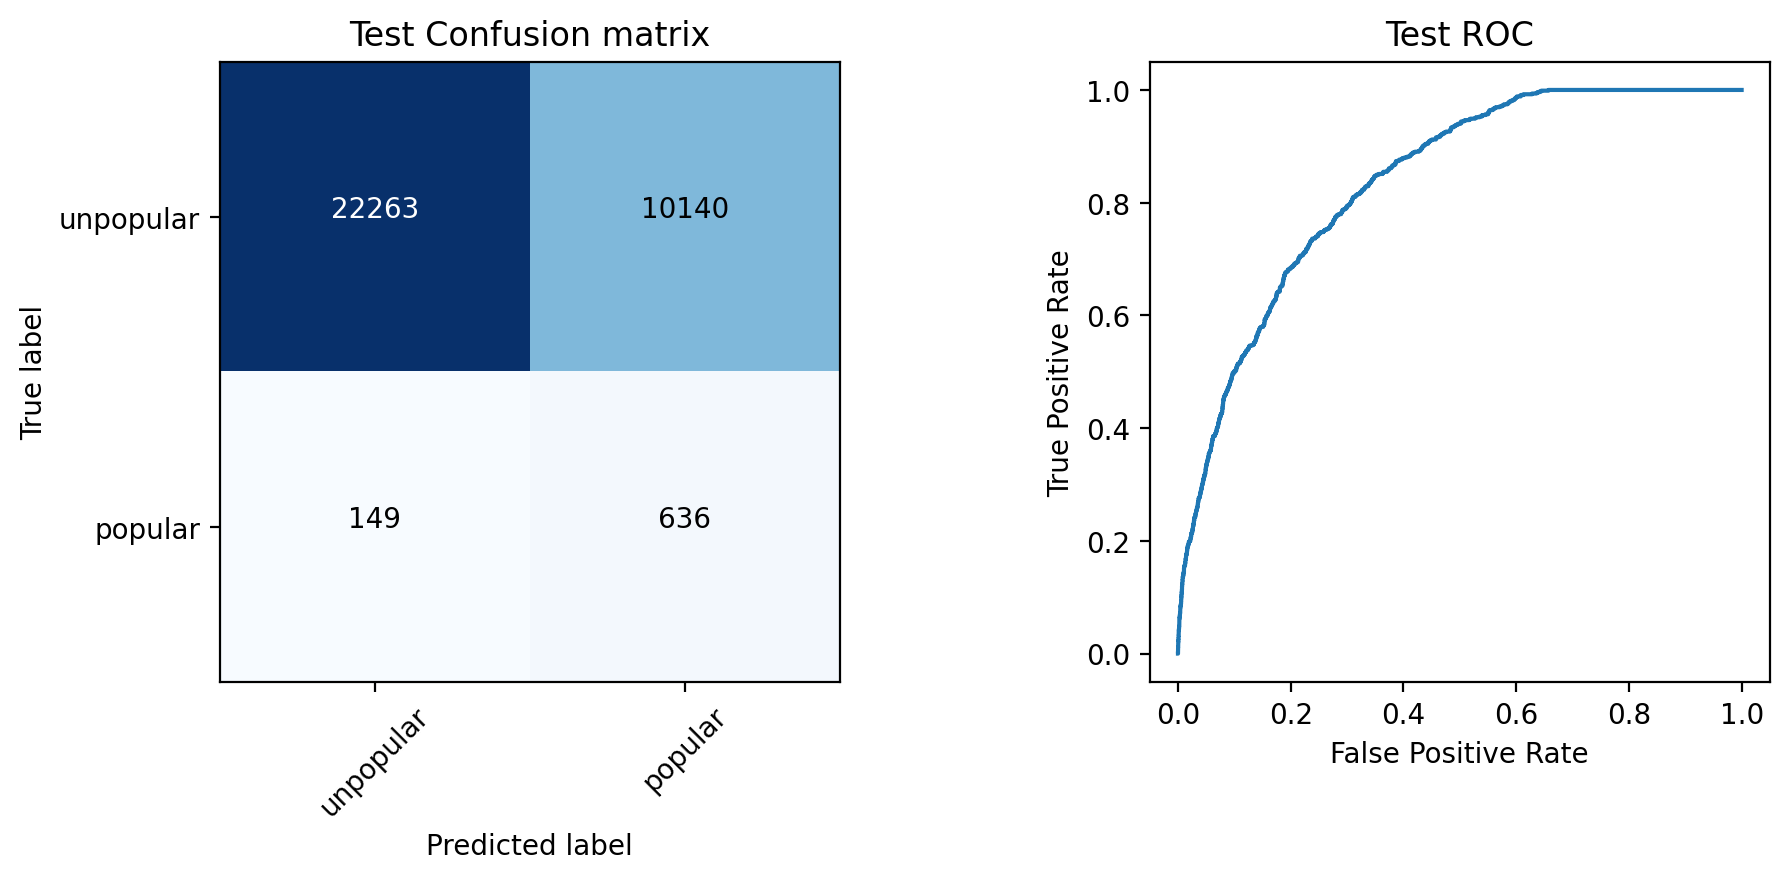

In [19]:
# Make model
model = make_model(X_train_lim, y_train_lim,depth_range=range(10,15),score='f1')
test_model(model,X_train_lim, X_test_lim, y_train_lim, y_test_lim)

So the limited data point model manages to correctly identify 85% of the popular articles, while the unlimited points model has a true positve accuracy of 80%, maybe theres a way to combine these models such that it can both correctly identify popular articles with a high enough certaining that all articles labeled popular are indeed popular.

Overall, the binary classification does the best. I'll move forwards to optimizing this model.